# <font color='brown'>Face Mask Detection Model - VGG19</font>

### Importing the Necessary Packages

In [1]:
from imutils import paths #To import path of the images in dataset
import matplotlib.pyplot as plt # To use plots for visualisation
import numpy as np # Array handling library
import os # For file handling

from tensorflow.keras.preprocessing.image import ImageDataGenerator # For Data Augmentation
from tensorflow.keras.applications.vgg19 import VGG19 # Deep Neural network model trained on Imagenet Dataset of Google

from tensorflow.keras.layers import AveragePooling2D # To Construct Pooling Layer
from tensorflow.keras.layers import Dropout # To Dropout the inputs for tackling overfitting 
from tensorflow.keras.layers import Flatten # Flatten the multidimension to single dimension
from tensorflow.keras.layers import Dense # Output layer - Fully connected
from tensorflow.keras.layers import Input # To create an Input layer without using Input Layer
from tensorflow.keras.models import Model # To group layers into an object 

from tensorflow.keras.optimizers import Adam # Optimizer for Training the Model

# Image Pre-Processing for Training the model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# One-Hot encoding of the labels
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split # To Split the Dataset into Train & Test
from sklearn.metrics import classification_report # To Print a Classification Report
from sklearn.metrics import confusion_matrix # To Print a Confusion matrix
import seaborn as sns # To plot a Confusion Matrix

### Creating an Object for Images and Label

In [2]:
image_paths = list(paths.list_images('/Users/vinith/Desktop/Dissertation/dataset')) # Getting the image paths
data = [] # list object to store images
labels = [] # list object to store labels  

### Looping over the image dataset to append them on respective lists

In [3]:
for image_path in image_paths: # looping over the image_paths 
    lab = image_path.split(os.path.sep)[-2] # extracting the class label from the filename
    
    # load the input_image with target resolution (224x224) and preprocess it
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)

    # update the data and labels lists, respectively
    data.append(img)
    labels.append(lab)

/Users/vinith/tensorflow-test/env/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Convert the data and labels to NumPy arrays

In [4]:
data = np.array(data, dtype="float32") # converting imagedata into array  
labels = np.array(labels) # converting label data into array 

In [5]:
data.shape

(4092, 224, 224, 3)

In [6]:
labels.shape

(4092,)

### One-Hot Encoding of Categorical Variable

In [7]:
# One-Hot encoding using LabelBinarizer() technique
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Train & Test Split

In [8]:
# Splitting the training and testing data in the ratio of 80/20.
(X_train, X_test, y_train, y_test) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=45)

In [9]:
X_train.shape

(3273, 224, 224, 3)

In [10]:
X_test.shape

(819, 224, 224, 3)

### Data Augmentation

In [11]:
# constructing the training image_generator for image transformation
augment = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

### Loading a Pre_trained Model MobilenetV2

In [12]:
# loading the MobileNetV2 pretrained model with weights of imagent dataset
# Also remove the last fully connected layer
bm = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

2022-12-09 01:37:46.991261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-09 01:37:46.991441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [13]:
# constructing the Output fully connected layer with output of 2 category
hm = bm.output
hm = AveragePooling2D(pool_size=(7, 7))(hm) # a layer with average pooling size of (7,7)
hm = Flatten(name="flatten")(hm) # Flatten the layer into single dimension
hm = Dense(128, activation="relu")(hm) # Output layer of 128
hm = Dropout(0.5)(hm) # Dropout 50% of the neurons
hm = Dense(2, activation="softmax")(hm) # Fianl Output Layer with 2 Categories

In [14]:
# Now place the created layers of output on the base model 
# to construct a model that produces output with 2 categories
main_model = Model(inputs=bm.input, outputs=hm)
main_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Freezing all the layers in the base model bm
for layer in bm.layers:
    layer.trainable = False

### Initialising the learning rate, Number of Epoch for training & Batch Size

In [16]:
lrate = 1e-4 # 0.0001 while calculating gradients 
epoch = 10 # No. of Epoch
bs = 32

### Model Compilation

In [17]:
opt = Adam(lr=lrate, decay=lrate / epoch)
main_model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

/Users/vinith/tensorflow-test/env/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Model Training

In [18]:
History = main_model.fit(augment.flow(X_train, y_train, batch_size=bs),
steps_per_epoch=len(X_train) // bs,
validation_data=(X_test, y_test),
validation_steps=len(X_test) // bs,
epochs=epoch)

Epoch 1/10


2022-12-09 01:37:47.759949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-09 01:37:48.092171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 1.0120 - accuracy: 0.7291

2022-12-09 01:39:02.875530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 96s 932ms/step - loss: 1.0120 - accuracy: 0.7291 - val_loss: 0.2729 - val_accuracy: 0.9341
Epoch 2/10
102/102 [==============================] - 103s 1s/step - loss: 0.3508 - accuracy: 0.9127 - val_loss: 0.1601 - val_accuracy: 0.9597
Epoch 3/10
102/102 [==============================] - 104s 1s/step - loss: 0.2324 - accuracy: 0.9398 - val_loss: 0.1174 - val_accuracy: 0.9695
Epoch 4/10
102/102 [==============================] - 108s 1s/step - loss: 0.1761 - accuracy: 0.9574 - val_loss: 0.0957 - val_accuracy: 0.9780
Epoch 5/10
102/102 [==============================] - 110s 1s/step - loss: 0.1292 - accuracy: 0.9651 - val_loss: 0.0907 - val_accuracy: 0.9768
Epoch 6/10
102/102 [==============================] - 112s 1s/step - loss: 0.1087 - accuracy: 0.9775 - val_loss: 0.0782 - val_accuracy: 0.9792
Epoch 7/10
102/102 [==============================] - 112s 1s/step - loss: 0.0842 - accuracy: 0.9803 - val_loss: 0.0760 - val_accuracy: 0.9792
Epoch 8/

### Making Prediction

In [19]:
# making predictions over the testing set
pred_idx = main_model.predict(X_test, batch_size=bs) # using the trained model to predict the labels of testing set

2022-12-09 01:55:58.225295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
pred_idx = np.argmax(pred_idx, axis=1) # using argmax function to predict probability of predicted labels

### Classification Report

In [21]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), pred_idx,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      1.00      0.98       433
without_mask       0.99      0.97      0.98       386

    accuracy                           0.98       819
   macro avg       0.98      0.98      0.98       819
weighted avg       0.98      0.98      0.98       819



### Confusion Matrix

In [22]:
cm = confusion_matrix((y_test.argmax(axis=1)), pred_idx, labels=[0,1])
cm

array([[431,   2],
       [ 12, 374]])

<AxesSubplot:>

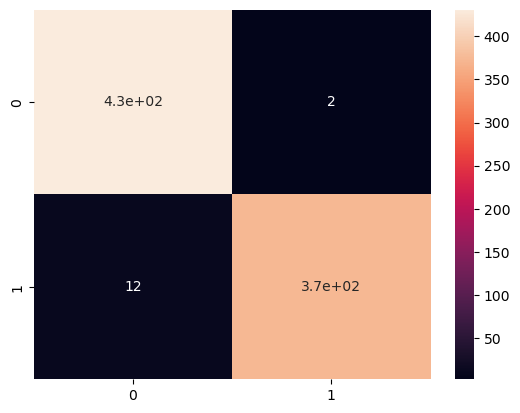

In [23]:
sns.heatmap(cm, annot=True)

### Plotting Accuracy and Loss Curves

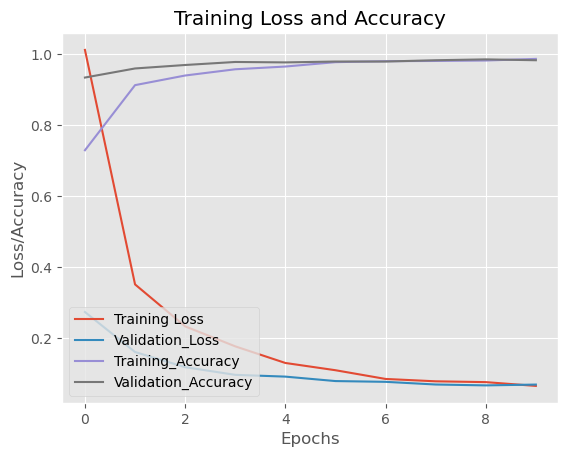

In [24]:
# plot the training loss and accuracy
n = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n), History.history["loss"], label="Training Loss")
plt.plot(np.arange(0, n), History.history["val_loss"], label="Validation_Loss")
plt.plot(np.arange(0, n), History.history["accuracy"], label="Training_Accuracy")
plt.plot(np.arange(0, n), History.history["val_accuracy"], label="Validation_Accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

### Reference
    FaceMaskDetection - Chandrikadeb7 - Github 